In [1]:
import copy
import os.path as osp

import sys
# 引入cam库路径
sys.path.append('./cam2')

import click
import cv2
import matplotlib.cm as cm
import numpy as np
import torch
import torch.hub
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms

from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

from main import get_device, get_classtable

# import resnet34 for dr classification
# 引入模型路径
sys.path.append('../../basic/train/')
from resnet import *
from dr_model import *
os.environ['CUDA_VISIBLE_DEVICES']='7'

import matplotlib.pyplot as plt

In [2]:
# 加载模型，并加载训练好的权重， 1024为input图像的尺寸，2为二分类
model = DRModel('rsn34', 1024, 2)
weights_file = '../../basic/train/dr_cls_yyy/ct_pos_recognition_0010_best.pth'
model.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [3]:
# 查看模型的权重，并获得相应层的name
model.state_dict

<bound method Module.state_dict of DRModel(
  (base): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [4]:
model = torch.nn.DataParallel(model).cuda()
model.eval()
# 查看模型的权重，并获得相应层的name， 注意在做过torch.nn.DataParallel前后，模型的参数名称有所改变，后者在前者
# 的基础上，增加了module.的前缀，比如之前名字为base.0的层，做完torch.nn.DataParallel之后，名字变为module.base.0
model.state_dict

<bound method Module.state_dict of DataParallel(
  (module): DRModel(
    (base): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [5]:
target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
# 我们取其中的5个层的结果，在标准的resnet模型种，这五个层，对应的名称为target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
# 这里我们可以通过如下代码查看标准resnet各层的name

# 可以通过model.state_dict查看
# 对应我们的模型，这5个层的名称为, 在做DataParallel之前，target_layers = ["base.2", "base.4", "base.5", "base.6", "base.7"]
# 在做DataParallel之后, target_layers = ["module.base.2", "module.base.4", "module.base.5", "module.base.6", "module.base.7"]

rsn_model = torchvision.models.resnet34()
rsn_model.state_dict
print('\n\n====> resnet34 layer names:')
for name, module in rsn_model.named_modules():
    print(name)
# 做完torch.nn.DataParallel之后，name会加上module.前缀
parallel_rsn_model = torch.nn.DataParallel(rsn_model).cuda()
print('\n\n====> parallel resnet34 layer names:')
print(parallel_rsn_model.state_dict)
# 使用gpu计算，也可以调用rsn_model.to(device)，这样不会改变模型各层的名称，实例如下：
rsn_model.to('cuda')
print('\n\n====> to device resnet34 layer names:')
print(rsn_model.state_dict)



====> resnet34 layer names:

conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.relu
layer2.3.conv2
layer2.3.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.2
layer3.2.conv1
layer3.2.bn1
layer3.2.relu
layer3.2.conv2
layer3.2.bn2
layer3.

In [6]:
# 输入图片路径，输出tensor[c,scale_size, scale_size]化的图像，和原始图像[scale_size, scale_size]
# 此函数种tensor[c,scale_size, scale_size]中的通道数c=1
def preprocess(image_path, scale_size=1024):
    raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    raw_image = cv2.resize(raw_image, (scale_size,scale_size))
    img1 = raw_image.copy()
    img1 = np.array(img1, dtype=np.float)
    img1 = img1
    print(img1.max())
    input_img = torch.from_numpy(img1)
    input_img = torch.unsqueeze(input_img, 0)
    return input_img, raw_image


# 工具函数，获得当前使用GPU或CPU运算
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device
device = get_device(True)
print(device)

Device: GeForce GTX 1080 Ti
cuda


In [7]:
# 记载示例图片
image_paths = ['../../examples/thread_3_1.jpg']
images = []
raw_images = []
print("Images:")
for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)
images = torch.stack(images)
images = images.float().cuda()
print(images.shape)

Images:
	#0: ../../examples/thread_3_1.jpg
255.0
torch.Size([1, 1, 1024, 1024])


In [8]:
# 构建GradCAM模型
gcam = GradCAM(model=model)
probs, ids = gcam.forward(images)

In [9]:
# target_class为要显示的分类的id，这里要特别注意，如果模型是N分类的，0 <= target_class < N
target_class = 0
ids_ = torch.LongTensor([[target_class]] * len(images)).cuda()

In [10]:
# 梯度回传，计算各层的heatmap结果
gcam.backward(ids=ids_)

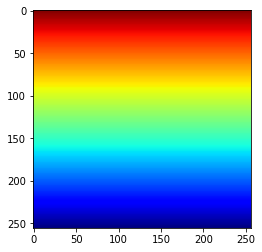

In [39]:
# 工具函数，显示各层的cam结果
def save_gradcam(filename, gcam, raw_image, paper_cmap=True):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3]*255
    img_rgb = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * img_rgb
    else:
        gcam = (cmap.astype(np.float) + img_rgb.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))
    
    # 绘制heatmap图
    cv2_img = cv2.imread(filename)
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.title(filename)
    plt.imshow(cv2_img)
    plt.show()
    
    
# 显示的颜色范围参照如下表：红色的值小，蓝色的值大，r->b, 0->255
def plot_ref_map():
    heatmap = np.arange(256*256)/256/256
    heatmap = np.resize(heatmap, [256,256])
    heatmap = cm.jet_r(heatmap)
    plt.figure()
    plt.imshow(heatmap)
plot_ref_map()

Generating Grad-CAM @module.base.2
	#0: 0 (1.00000)


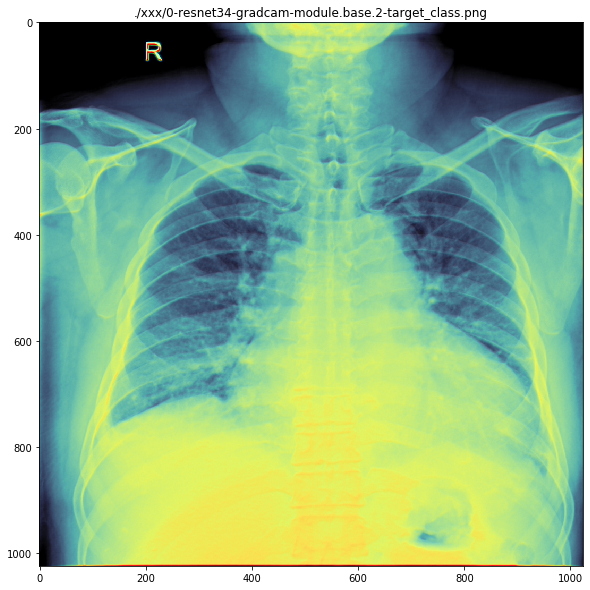

Generating Grad-CAM @module.base.4
	#0: 0 (1.00000)


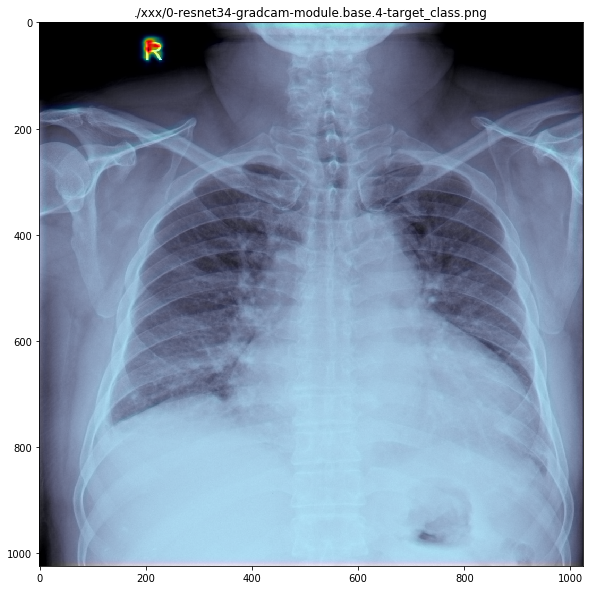

Generating Grad-CAM @module.base.5
	#0: 0 (1.00000)


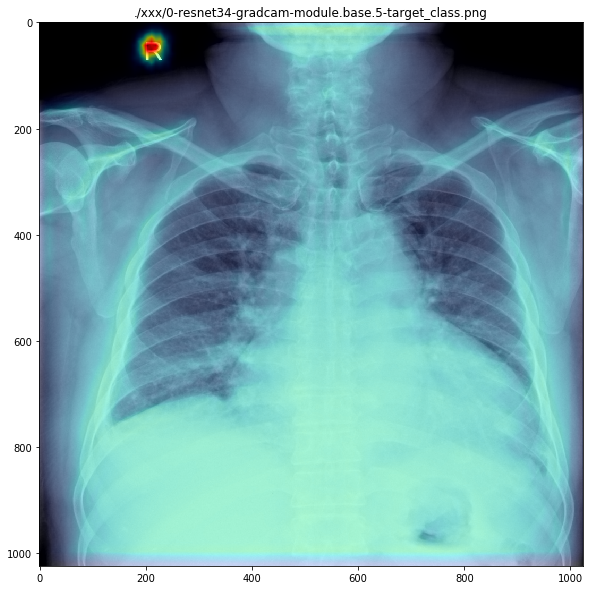

Generating Grad-CAM @module.base.6
	#0: 0 (1.00000)


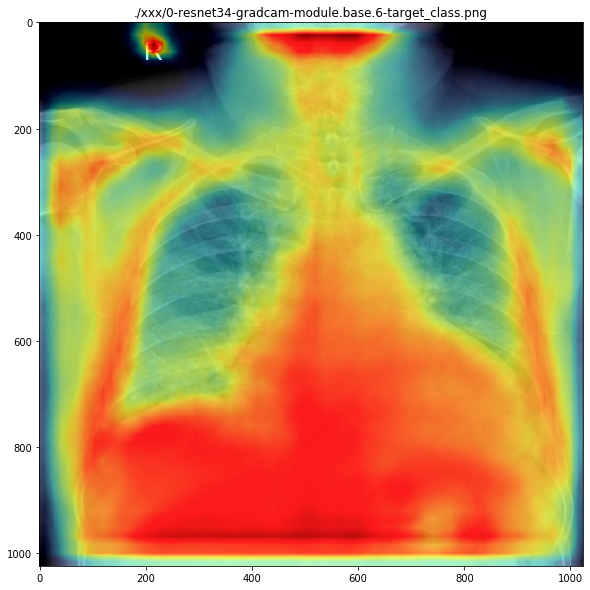

Generating Grad-CAM @module.base.7
	#0: 0 (1.00000)


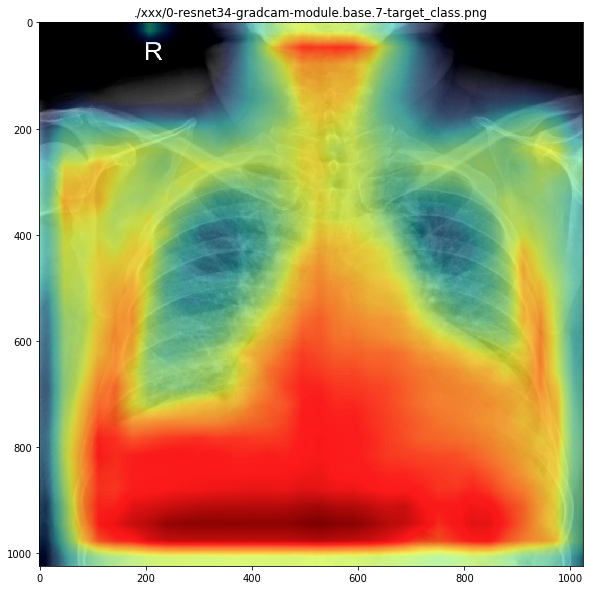

In [41]:
# 需要输出的热度图的层的name
target_layers = ["module.base.2", "module.base.4", "module.base.5", "module.base.6", "module.base.7"]
# 设置热度图的输出路径
output_dir = './xxx' 
os.makedirs(output_dir, exist_ok=True)
# 遍历每个输出层
for target_layer in target_layers:
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    regions = gcam.generate(target_layer=target_layer)
    for j in range(len(images)):
        print("\t#{}: {} ({:.5f})".format(j, target_class, float(probs[ids == target_class])))
        save_gradcam(filename=osp.join(output_dir,"{}-{}-gradcam-{}-{}.png".format(j, "resnet34", target_layer, 'target_class'),),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )